## Titanic ML from Disaster

### 1. Setup

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

### 2. Import Data

In [53]:
dir = os.getcwd()
train_data = pd.read_csv(os.path.join(dir,'input', 'train.csv'))
test_data = pd.read_csv(os.path.join(dir,'input', 'test.csv'))

### 3. Exploratory Data Analysis (EDA)

In [54]:
def basic_eda_info (df, name='DataFrame'):

    print(f'=== {name}: Basic Information ===')
    print(f'Shape: {df.shape}')

    print('='*60)
    print('=== Head of DataFrame ===')
    display(df.head())

    with pd.option_context('display.float_format', '{:,.2f}'.format):
        print('=== Numeric Describe ===')
        display(df.describe())

In [55]:
from scipy.stats import pointbiserialr

def correlation_analysis(df, target_col=None, numeric_cols=None):

    if target_col is None:
        raise ValueError("Please specify the target_col (dependent variable).")

    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.to_list()

    if target_col in numeric_cols:
        numeric_cols.remove(target_col)

    if len(df[target_col].unique()) > 2:
        raise ValueError("For classification, the target_col must be binary (e.g., 0 or 1).")
    correlations = {}
    for col in numeric_cols:
        corr, _ = pointbiserialr(df[target_col], df[col])
        correlations[col] = corr

    corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
    corr_df = corr_df.sort_values(by='Correlation', ascending=False)

    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', cbar=False, fmt='.2f')
    plt.title('Point-Biserial Correlation Heatmap (Classification)')
    plt.show()

In [56]:
basic_eda_info(train_data)

=== DataFrame: Basic Information ===
Shape: (891, 12)
=== Head of DataFrame ===


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


=== Numeric Describe ===


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


### 4. Data Cleaning

#### 4.1 Missing data

In [57]:
print("Missing in train_data:")
print(train_data.isnull().sum())

print("."*50)

Missing in train_data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
..................................................


#### 4.2 Missing data on Age

In [58]:
def replace_missing_age (df):
    df = df.reset_index()
    df = df.set_index('PassengerId')

    df['Title'] = df.Name.str.extract(r' ([A-Za-z]+)\.', expand=False)

    # Standarize titles
    mapping = {'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs'}
    df['Title'] = df['Title'].replace(mapping)
    title_medians = df.groupby('Title')['Age'].median().to_dict()

    df['Age'] = df.apply(
        lambda row: title_medians[row['Title']] if pd.isnull(row['Age']) else row['Age'],
        axis=1
    )

    title_std = ~df['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master'])
    df.loc[title_std, 'Title'] = df.loc[title_std, 'Sex'].map({'male': 'Mr', 'female': 'Mrs'})

    return df

#### 4.3 Missing data on Cabin

In [59]:
def replace_cabin (df):

    df.Cabin = df.Cabin.fillna('Z00 ')
    df['Deck'] = df['Cabin'].str.split(' ').str[0].str[0]

    return df

#### 4.4 Missing data on Embarked & Fare

In [60]:
def replace_missing_embarked_fare (df):
    
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    return df

### 5. Featuring Engineering

#### 5.1 Merging supplementary data

In [61]:
def add_features_columns (df):

    # Creating new family_size column
    df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['Family_Size'] == 1).astype(int)

    # Creating Fare per person
    df['Fare_Per_Person']= df['Fare'] / (df['Family_Size'])
        
    # Creating Age times class
    df['Age*Class'] = df['Age'] * df['Pclass']
    df['Age*Fare'] = df['Age'] * df['Fare']

    return df

In [62]:
def add_factorize(df):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    if len(categorical_cols) > 0:
        print(f"Factorizing categorical columns: {list(categorical_cols)}")
        for col in categorical_cols:
            df[col] = pd.factorize(df[col])[0]  # Factorize categories into numeric codes
    
    return df

#### 5.2 Standarizing the data

In [63]:
def discretise_numeric(train, test, numeric_cols, no_bins=10):
    """
    Discretizes the specified numeric columns into bins, leaving other columns unchanged.
    """
    # Reset indices for consistent processing
    train = train.reset_index()
    test = test.reset_index()
    
    # Get the sizes of train and test datasets
    N = len(train)
    M = len(test)
    
    # Ensure unique indices for test by offsetting
    test.index += N  # Shift test index to avoid overlaps with train
    
    # Combine train and test for consistent discretization
    joint_df = pd.concat([train, test], axis=0)
    
    # Loop through only the specified numeric_cols to discretize
    for column in numeric_cols:
        if column in joint_df.columns:
            # Apply pd.qcut to discretize into quantile-based bins
            joint_df[column] = pd.qcut(joint_df[column], no_bins, labels=False, duplicates='drop')
        else:
            print(f"Warning: Column '{column}' not found in the dataset.")

    # Split the combined dataset back into train and test
    train = joint_df.iloc[:N].reset_index(drop=True)
    test = joint_df.iloc[N:].reset_index(drop=True)
    
    return train, test

In [64]:
from sklearn.preprocessing import StandardScaler

def standarize_values(train, test, numeric_cols):
    """
    Standardizes specified numeric columns in the training and test datasets,
    leaving all other columns unchanged.
    """
    # Reset indices for consistent processing
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    # Initialize the scaler
    scaler = StandardScaler()

    # Fit the scaler on the training set for the specified numeric columns
    scaler.fit(train[numeric_cols])

    # Transform only the specified numeric columns
    train_scaled = scaler.transform(train[numeric_cols])
    test_scaled = scaler.transform(test[numeric_cols])

    # Create DataFrames for the standardized numeric columns
    train_scaled_df = pd.DataFrame(train_scaled, columns=numeric_cols, index=train.index)
    test_scaled_df = pd.DataFrame(test_scaled, columns=numeric_cols, index=test.index)

    # Replace the specified numeric columns with the standardized versions
    train[numeric_cols] = train_scaled_df
    test[numeric_cols] = test_scaled_df

    return train, test

In [65]:
def equal_dataframes (train, test):
    
    # Get the columns that are in the test DataFrame
    common_columns = test.columns

    # Add 'Survived' to the list of columns
    columns_to_keep = list(common_columns)

    # Filter the train DataFrame to keep only these columns
    train_filtered = train[columns_to_keep]

    return train_filtered, test

#### 5.3 Final features & cleaning selection

In [66]:
def clean_df (df):
    
    # Do all the steps together
    df = replace_missing_age(df)
    df = replace_missing_embarked_fare(df)
    df = replace_cabin(df)
    df = add_features_columns(df)
    df = add_factorize(df)
    
    # Drop unnecessary columns
    df = df.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1)
    
    return df

### 6. Data set analysis & premodeling work

In [67]:
train = clean_df(train_data)
test = clean_df(test_data)

# Only discretise numerical columns, not binaries
tr, te = discretise_numeric(train, test, numeric_cols=['Age', 'Fare'])

# Only standarize numerical columns, not discrets, not binaries
tr, te = standarize_values(tr, te, numeric_cols=['Fare_Per_Person', 'Age*Class', 'Age*Fare'])
train_final, test_final = equal_dataframes(tr, te)

Factorizing categorical columns: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Deck']
Factorizing categorical columns: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Deck']


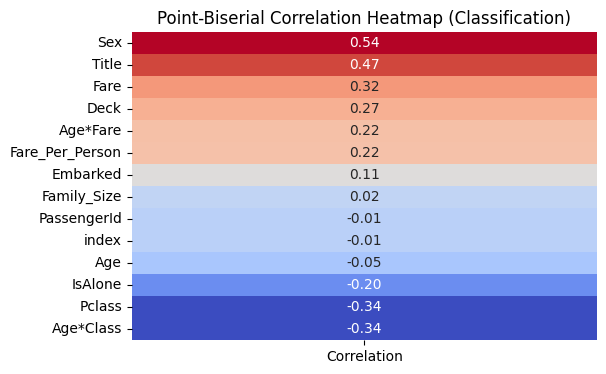

In [68]:
correlation_analysis(tr, target_col="Survived")

### 7. Prediction and Submission

In [69]:
y = train_final['Survived']

X = train_final.drop(['Survived', 'PassengerId'], axis=1) #Check to leave or not 'index' column, sometimes it predicts better with it
X_test = test_final.drop(['Survived', 'PassengerId'], axis=1)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.2,
    subsample=0.8,
    random_state=1
)

model.fit(X, y)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=50, random_state=1,
                           subsample=0.8)

In [71]:
# Predict on the test data
predictions = model.predict(X_test).astype('int')

# Export to .csv file
output = pd.DataFrame({'PassengerID': test_final.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print('Done')

Done
